In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from autograd import elementwise_grad, grad
import autograd.numpy as np
import scipy
from scipy.optimize import minimize
import copy
import GPy

In [2]:
def sal(par,y):
    assert len(par)>=4, "not enough params"
    return par[0]+par[1]*np.sinh(par[2]*np.arcsinh(y) + par[3])

d_sal = elementwise_grad(sal,1)

def sal_comp(par,y,n):
    assert len(par)>=4*n, "not enough params"
    comp = copy.deepcopy(y)
    for i in range(0,n):
        comp = sal(par[4*i:],comp)
    return comp

def d_sal_comp(par,y,n):
    assert len(par)>=4*n, "not enough params"
    comp = copy.deepcopy(y)
    d_comp = 1
    for i in range(0,n):
        d_comp *= d_sal(par[4*i:],comp)
        comp = sal(par[4*i:],comp)
    return d_comp

def cov_kernel(gamma,x):
    return np.exp(-gamma*(np.abs(x))**2)

def nllf(par):
    phi_y = sal_comp(par,betas,n)
    phi_y = phi_y[np.newaxis].reshape(-1,1)
    t_phi_y = np.transpose(phi_y)
    
    cov_xx = cov_kernel(gamma,np.log(np.exp(phi_y) @ np.exp(-(t_phi_y))))
    gaussian_params = 0.5 * (t_phi_y) @ np.linalg.inv(cov_xx) @ phi_y
    
    chain_d_sal = d_sal_comp(par,betas,n)
    
    return  0.5 * np.log(np.linalg.det(cov_xx)) + gaussian_params - sum(np.log(chain_d_sal))


In [3]:
CSV_FIlE = "japan.csv"

In [4]:
df = pd.read_csv(CSV_FIlE)

In [5]:
df.columns

Index(['year', 'age', 'female', 'male', 'total'], dtype='object')

In [6]:
df_50 = df[(df["age"]==50)]

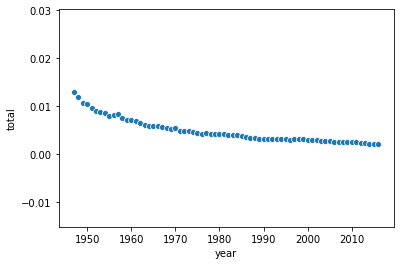

In [7]:
sns.scatterplot(df_50["year"],df_50["total"])

In [8]:
n = 2
gamma = 2
betas = np.array(df_50["total"])
year = np.array(df_50["year"])
betas.shape

(70,)

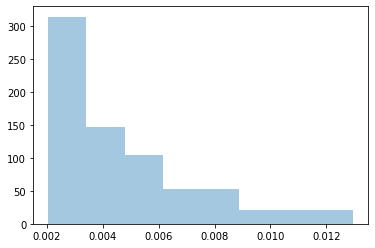

In [9]:
sns.distplot(betas, kde=False, norm_hist=True)

In [10]:
len(betas[betas<0.005])/len(betas)

0.6571428571428571

In [ ]:
res = minimize(nllf, np.random.rand(4*n), method='L-BFGS-B')
while res.success == False:
    try:
        res = minimize(nllf, np.random.rand(4*n), method='L-BFGS-B')
#         rand = np.random.uniform(low=-5, high=5, size=(4*n, 1))
#         res = minimize(nllf, rand , method='L-BFGS-B')
#         print(rand)
    except:
        pass

 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:divide by zero encountered in log
 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning:invalid value encountered in subtract
 /home/chen/work/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning:invalid value encountered in det


In [ ]:
res

In [ ]:
res.x

In [ ]:
transformed_betas = sal_comp(res.x,betas,n)

In [ ]:
sns.distplot(transformed_betas)

In [ ]:
betas

In [ ]:
transformed_betas

In [ ]:
# from sklearn.model_selection import train_test_split

kernel = GPy.kern.Matern52(1)*GPy.kern.Brownian(1)*GPy.kern.RBF(1)
per = 0.7
length = len(year)
X_train, y_train = year[np.newaxis].reshape(-1,1)[:int(0.7*len(year))], transformed_betas[np.newaxis].reshape(-1,1)[:int(0.7*len(year))]
X_test, y_test = year[np.newaxis].reshape(-1,1)[int(0.7*len(year)):], transformed_betas[np.newaxis].reshape(-1,1)[int(0.7*len(year)):]
model = GPy.models.GPRegression(X_train, y_train,kernel = kernel)

model.optimize()
model.plot()
print(model)

print(X_test.shape,y_test.shape)
plt.scatter(X_test,y_test)
plt.show()

In [ ]:
kernel = GPy.kern.Matern52(1)
per = 0.7
length = len(year)
X_train, y_train = year[np.newaxis].reshape(-1,1)[:int(0.7*len(year))], betas[np.newaxis].reshape(-1,1)[:int(0.7*len(year))]
X_test, y_test = year[np.newaxis].reshape(-1,1)[int(0.7*len(year)):], betas[np.newaxis].reshape(-1,1)[int(0.7*len(year)):]
model = GPy.models.GPRegression(X_train, y_train,kernel = kernel)

model.optimize()
model.plot()
print(model)

print(X_test.shape,y_test.shape)
plt.scatter(X_test,y_test)
plt.show()